# Assignment 3: CIFAR 10 Dataset ConvNet
**2 GPUs**<br>
Abdul-Rahman Abdel-Fattah

In [1]:
try:
    import py7zr
    import torchmetrics, mlxtend
    from torchsummary import summary
except:
    !pip install py7zr
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    !pip install torchsummary
    
    import torchmetrics, mlxtend
    import torchsummary
    import py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/66.7 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 2.0/2.1 MB 59.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 25.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 11.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.0 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 75.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.2 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

# Import the visualization library
import matplotlib.pyplot as plt
from matplotlib import image

# Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Torchvision
from torchvision import datasets, transforms

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

print(f"PyTorch version: {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else None
device

PyTorch version: 2.0.0


'cuda'

# Importing the Data

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [4]:
input_dir = os.path.join("/kaggle", "input", "cifar-10/")
output_dir = os.path.join("/kaggle", "output", "cifar-10/")

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

input_dir, output_dir

('/kaggle/input/cifar-10/', '/kaggle/output/cifar-10/')

In [5]:
zip_files = [file for file in os.listdir(input_dir) if file[-3:] == ".7z"]

for file in zip_files:
    print(f"Extracting the file {file}")
    
    with py7zr.SevenZipFile(os.path.join(input_dir, file), mode='r') as z:
        z.extractall(path=output_dir)
    
    print(f"Extraction Complete")

Extracting the file test.7z


Extraction Complete
Extracting the file train.7z


Extraction Complete


# Reading the Training Data

In [6]:
train_labels = pd.read_csv(input_dir + "trainLabels.csv", index_col=["id"]).squeeze()
label_encoder = LabelEncoder().fit(train_labels)

classes = label_encoder.classes_

print('Classes in CIFAR10')
print(classes)

print("\nThe number of classes is")
print(len(classes))

print("\nNumber of training data records")
print(train_labels.shape[0])

print("\nThe first 5 labels")
print(train_labels.head(5))

Classes in CIFAR10
['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']

The number of classes is
10

Number of training data records
50000

The first 5 labels
id
1          frog
2         truck
3         truck
4          deer
5    automobile
Name: label, dtype: object


In [7]:
train_data = []
for i in range(1, len(train_labels) + 1):
    img = image.imread('/kaggle/output/cifar-10/train/' + str(i) + ".png")
    train_data.append([img, label_encoder.transform([train_labels[i]])[0]])
    
len(train_data)

50000

In [8]:
label_encoder.inverse_transform([train_data[0][1]]), train_data[0][0].shape

(array(['frog'], dtype=object), (32, 32, 3))

# <a id="visualize">Visualizing Sample Images</a>

(-0.5, 31.5, 31.5, -0.5)

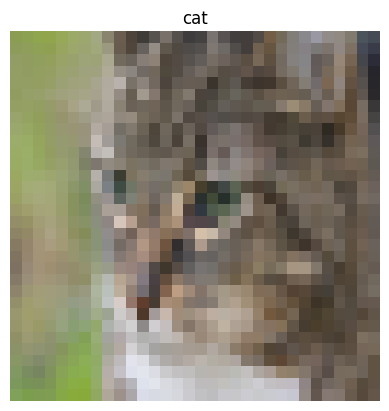

In [9]:
idx = np.random.randint(50000)

plt.imshow(train_data[idx][0])
plt.title(label_encoder.inverse_transform([train_data[idx][1]])[0])
plt.axis(False)

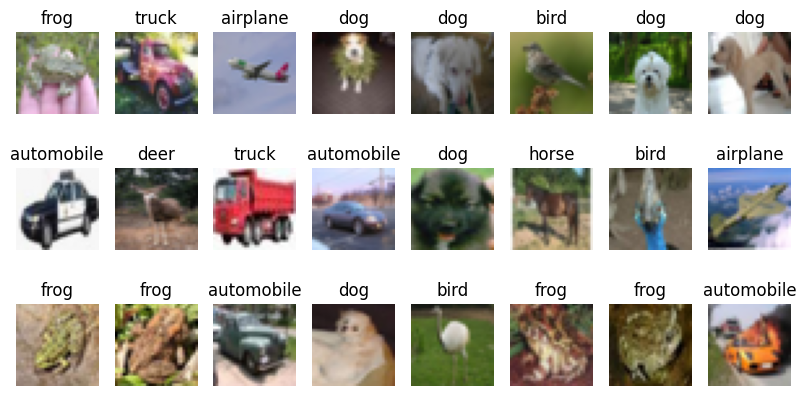

In [10]:
plt.figure(figsize=(10, 5))
 
num_rows = 3
num_cols = 8

for idx in range(num_rows * num_cols):
    idx_to_show = np.random.choice(len(train_labels))
    img    = train_data[idx_to_show][0]
    label  = label_encoder.inverse_transform([train_data[idx_to_show][1]])[0]
        
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

# Creation of and Training The Model

In [11]:
class Configs:
    batch_size = 32,
    shuffle    = True,
    epochs     = 100
    
configs = Configs()

## <a id="torch">Pytorch Model</a>

### Creation

In [12]:
class CNN_Model(nn.Module):
    def __init__(self, input_shape: int = 3, output_shape: int = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [13]:
model = CNN_Model()

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

# Running on multiple GPUs
model = nn.DataParallel(model, device_ids=[0, 1])

model.to(device)
#summary(model, (3, 32, 32))

DataParallel(
  (module): CNN_Model(
    (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=1600, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Data Preparation

In [14]:
train_dataloader = DataLoader(
    train_data, 
    batch_size   = configs.batch_size[0],
    shuffle      = configs.shuffle,
)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {configs.batch_size[0]}")

Length of train dataloader: 1563 batches of 32


### Training the Model

In [15]:
model.train()
model.to(device)

for epoch in tqdm(range(configs.epochs)):
    print(f"Epoch: {epoch+1}\n---------")

    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        # Send data to GPU
        X, y = X.reshape(-1, 3, 32, 32).to(device), y.to(device)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        #  Forward pass
        y_logits = model(X)
        y_preds  = torch.softmax(y_logits, dim=1)
        #  Calculate loss
        loss = loss_fn(y_logits, y) 
        #  Loss backward
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        train_acc += accuracy(y, y_preds.argmax(dim=1)) # Go from logits -> pred labels
        
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1
---------


Train loss: 2.27346 | Train accuracy: 0.14%
Epoch: 2
---------


Train loss: 2.10981 | Train accuracy: 0.21%
Epoch: 3
---------


Train loss: 1.92275 | Train accuracy: 0.29%
Epoch: 4
---------


Train loss: 1.80846 | Train accuracy: 0.34%
Epoch: 5
---------


Train loss: 1.73898 | Train accuracy: 0.37%
Epoch: 6
---------


Train loss: 1.68268 | Train accuracy: 0.39%
Epoch: 7
---------


Train loss: 1.63640 | Train accuracy: 0.41%
Epoch: 8
---------


Train loss: 1.58965 | Train accuracy: 0.42%
Epoch: 9
---------


Train loss: 1.54932 | Train accuracy: 0.44%
Epoch: 10
---------


Train loss: 1.50976 | Train accuracy: 0.45%
Epoch: 11
---------


Train loss: 1.47122 | Train accuracy: 0.47%
Epoch: 12
---------


Train loss: 1.44054 | Train accuracy: 0.48%
Epoch: 13
---------


Train loss: 1.40580 | Train accuracy: 0.49%
Epoch: 14
---------


Train loss: 1.37365 | Train accuracy: 0.50%
Epoch: 15
---------


Train loss: 1.34799 | Train accuracy: 0.51%
Epoch: 16
---------


Train loss: 1.31671 | Train accuracy: 0.52%
Epoch: 17
---------


Train loss: 1.29010 | Train accuracy: 0.53%
Epoch: 18
---------


Train loss: 1.25948 | Train accuracy: 0.55%
Epoch: 19
---------


Train loss: 1.23515 | Train accuracy: 0.56%
Epoch: 20
---------


Train loss: 1.20881 | Train accuracy: 0.56%
Epoch: 21
---------


Train loss: 1.18031 | Train accuracy: 0.57%
Epoch: 22
---------


Train loss: 1.15538 | Train accuracy: 0.58%
Epoch: 23
---------


# Prediction on Test Images

In [ ]:
idxs = np.random.choice(1000, 24)

test_data = []
for i in idxs:
    img = image.imread('/kaggle/output/cifar-10/test/' + str(i) + ".png")
    test_data.append(img)
    
test_data = np.array(test_data)
test_data.shape

In [ ]:
model.eval()
test_labels = model(torch.tensor(test_data.reshape(-1, 3, 32, 32)).to(device)).argmax(dim=1)
test_labels = label_encoder.inverse_transform(np.array(test_labels.cpu()))

test_labels

In [ ]:
idx = np.random.randint(18)

plt.imshow(test_data[idx])
plt.title(test_labels[idx])
plt.axis(False)

In [ ]:
plt.figure(figsize=(15, 5))
 
num_rows = 3
num_cols = 8

for idx in range(num_rows * num_cols):
    img         = test_data[idx]
    label       = test_labels[idx]
    
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

# Submission

In [ ]:
# putting the model in evaluation mode
model.eval()

## Emptying some RAM storage

In [ ]:
%whos
del(train_dataloader)
del(train_data)

## Reading the test dataset

In [ ]:
no_of_test_images = len(os.listdir("/kaggle/output/cifar-10/test"))
model.eval()
test_data = []

for i in range(1, no_of_test_images + 1):
    img = image.imread('/kaggle/output/cifar-10/test/' + str(i) + ".png")
    test_data.append([img, i]) 

In [ ]:
test_dataloader = DataLoader(
    test_data, 
    batch_size   = configs.batch_size[0],
    shuffle      = False,
)

In [ ]:
len(test_data)

## Predicting the results

In [ ]:
ids = []
labels = []

for (X, y) in tqdm(test_dataloader):
    X = X.reshape(-1, 3, 32, 32)
    y_logits = model(X)
    y_preds  = torch.softmax(y_logits, dim=1).argmax(dim=1).cpu()
    labels += label_encoder.inverse_transform(y_preds).tolist()
    ids += y.squeeze().tolist()



In [ ]:
len(ids), len(labels), ids[1], labels[1]

In [ ]:
# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    'id': ids,
    'label': labels
})

# Save the submission file with class labels
submission_df.to_csv('/kaggle/working/submission3.csv', index=False)